Fit CNN in PyTorch
===


## Imports

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Number of classes in the dataset
num_classes = 8

# Batch size for training (change depending on how much memory you have)
batch_size_im = 90
batch_size_ft = 30

# Number of epochs to train for 
num_epochs_im = 10
num_epochs_ft = 10

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract_im = True
feature_extract_ft = False

input_size = 224

img_dir = "../finetuning_torchvision_data/360 Rocks"
csv_file = "../finetuning_torchvision_data/mds_360.csv"

## Functions and classes

In [37]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=14, is_inception=False):
    """
    handles the training and validation of a given model. At the end of
    training returns the best performing model. After each epoch, the training and validation
    accuracies are printed
    """
    
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_r2 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        score = r2_score(labels.detach().numpy(), outputs.detach().numpy())
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        global tmp_labels, tmp_outputs
                        tmp_labels = labels
                        tmp_outputs = outputs
                        score = r2_score(labels.detach().numpy(), outputs.detach().numpy())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics # TODO -> check if this is correct (maybe calculate MSE?)
                running_loss += loss.item() * inputs.size(0)
                running_r2 += score

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_r2 / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f}')

            # deep copy the model
            if phase == 'val' and best_acc == None:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
    
    # maybe not necessary, but lets check later if it's a handy feature
    
   #     # save model after each epoch
   #     torch.save({
   #         'epoch': epoch,
   #         'model_state_dict': model.state_dict(),
   #         'optimizer_state_dict': optimizer.state_dict(),
   #         'loss': loss,
   #         ...
   #         }, PATH)
    
        print() # empty line between epochs

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True
    return None


class RocksData(Dataset):
    def __init__(self, df, root_dir):
        super(RocksData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.root_dir = root_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2) 
        img = self.preprocess_input(img)
        return img, kp2
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)
    def load_img(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]        
        img = cv2.imread(img_path)
        img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img

## Load Data

In [38]:
df = pd.read_csv(csv_file)

train, test = train_test_split(df, test_size=90, random_state=0)
train_dataset = RocksData(train.reset_index(drop=True), img_dir)
test_dataset = RocksData(test.reset_index(drop=True), img_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
test_loader = DataLoader(test_dataset, batch_size=batch_size_im)

dataloaders_dict = {"train":train_loader,"val":test_loader}

## Create intermediate model

In [39]:
# TODO change later from resnet18 to resnet50
model_im = models.resnet50(pretrained=True)
set_parameter_requires_grad(model_im, feature_extract_im)
num_ftrs = model_im.fc.in_features
model_im.fc = nn.Linear(num_ftrs, num_classes)

### Optimizer

In [40]:
loglr = -2.2200654426745987
lr_im = 10 ** loglr

# Send the model to GPU
model_im = model_im.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update_im = model_im.parameters()
print("Params to learn:")
if feature_extract_im:
    params_to_update_im = []
    for name,param in model_im.named_parameters():
        if param.requires_grad == True:
            params_to_update_im.append(param)
            print("\t",name)
else:
    for name,param in model_im.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_im = optim.Adam(params_to_update_im, lr = lr_im) # for the intermediate model

Params to learn:
	 fc.weight
	 fc.bias


### Run Training and Validation Step

**Intermediate model**

In [41]:
# Setup the loss fxn

loss_name = "L2"

if loss_name == "L1":
    criterion = torch.nn.L1Loss()
elif loss_name == "L2":
    criterion = torch.nn.MSELoss()
elif loss_name == "smooth_L1":
    criterion = torch.nn.SmoothL1Loss()
elif loss_name == "huber":
    criterion = torch.nn.HuberLoss()

# Train and evaluate
model_ft, hist = train_model(model_im, dataloaders_dict, criterion, optimizer_im, num_epochs = num_epochs_im)

Epoch 1/10
----------
train Loss:  10.0941 Acc: -12277.0023
val Loss:  6.1467 Acc: -7125.0966

Epoch 2/10
----------
train Loss:  11.7208 Acc: -13680.0149
val Loss:  2.5017 Acc: -2973.2714

Epoch 3/10
----------
train Loss:  2.5713 Acc: -2885.9245
val Loss:  7.6893 Acc: -9090.7989

Epoch 4/10
----------
train Loss:  5.9648 Acc: -7051.7423
val Loss:  0.1820 Acc: -207.3851

Epoch 5/10
----------
train Loss:  1.6447 Acc: -1829.0315
val Loss:  4.4756 Acc: -5251.6966

Epoch 6/10
----------
train Loss:  2.8071 Acc: -3333.5759
val Loss:  0.1290 Acc: -150.2559

Epoch 7/10
----------
train Loss:  1.1179 Acc: -1254.0694
val Loss:  2.3464 Acc: -2783.8831

Epoch 8/10
----------
train Loss:  1.3437 Acc: -1599.1125
val Loss:  0.1967 Acc: -231.9169

Epoch 9/10
----------
train Loss:  0.7838 Acc: -888.6938
val Loss:  1.1737 Acc: -1363.7405

Epoch 10/10
----------
train Loss:  0.5998 Acc: -712.7728
val Loss:  0.2586 Acc: -323.1091

Training complete in 6m 35s
Best val Acc: -150.255894


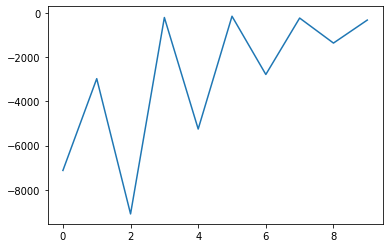

In [42]:
plt.plot(hist)

## Create finetuned model

### Set all parameters to trainable

In [30]:
set_parameter_requires_grad(model_ft, feature_extract_ft)

### different batch size

In [31]:
train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
test_loader = DataLoader(test_dataset, batch_size=batch_size_ft)

dataloaders_dict = {"train":train_loader,"val":test_loader}

### Optimizer

In [ ]:
lr_ft = 0.0001

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update_ft = model_ft.parameters()
print("Params to learn:")
if feature_extract_ft:
    params_to_update_ft = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update_ft.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update_ft, lr = lr_ft, momentum = 0.9) # for the finetuning

### Run Training and Validation Step

**Finetuned model**

In [ ]:
# Setup the loss fxn

loss_name = "L2"

if loss_name == "L1":
    criterion = torch.nn.L1Loss()
elif loss_name == "L2":
    criterion = torch.nn.MSELoss()
elif loss_name == "smooth_L1":
    criterion = torch.nn.SmoothL1Loss()
elif loss_name == "huber":
    criterion = torch.nn.HuberLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs = num_epochs_ft)

In [ ]:
plt.plot(hist)

## Save model

In [19]:
PATH = "CNN_checkpoints/state_dict_model_ft.pt"
torch.save(model_ft.state_dict(), PATH)

## Load model

In [ ]:
model_ft = models.resnet18()
set_parameter_requires_grad(model_ft, feature_extract_ft)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft.load_state_dict(torch.load(PATH))

model_ft.eval()